# Parameter Distributions

These figures and tables detail the distributions of the aerosol size distribution parameters and meteorological parameters which are critical to driving droplet activation calculations in MARC.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="ticks", context="talk")

import xarray as xr
import pandas as pd
import numpy as np

/Users/daniel/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


All of the data for creating these plots were taken from a MARC simulation running a present-day aerosol emissions scenario. In that simulation, we output instaneous snapshots of the complete aerosol size distribution for the entire atmosphere, as well as sub-grid scale vertical velocities, temperatures, pressures, and other thermodynamic data. The snapshots were saved in intervals of 5 days, 6 hours in order to sample from the complete diurnal cycle in all seasons. This yielded 70 samples of our 2-degree, 30-layer model output, at about ~7 GB on disk.

In [2]:
MARC_data = xr.open_dataset("../aerosol_dists/aerosol_dists.nc")
print(MARC_data)

<xarray.Dataset>
Dimensions:    (lat: 96, lev: 30, lon: 144, nbnd: 2, time: 70)
Coordinates:
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * lev        (lev) float64 3.643 7.595 14.36 24.61 38.27 54.6 72.01 87.82 ...
  * time       (time) object    1-01-01 00:00:00    1-01-06 06:00:00 ...
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 -78.63 ...
  * nbnd       (nbnd) int64 0 1
Data variables:
    WSUB       (time, lev, lat, lon) float32 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 ...
    T          (time, lev, lat, lon) float32 261.115 261.115 261.115 261.115 ...
    Q          (time, lev, lat, lon) float32 1.89301e-06 1.89301e-06 ...
    PS         (time, lat, lon) float32 67985.1 67985.1 67985.1 67985.1 ...
    time_bnds  (time, nbnd) float64 0.0 0.0 0.0 5.25 5.25 10.5 10.5 15.75 ...
    hyam       (lev) float64 0.003643 0.007595 0.01436 0.02461 0.03827 ...
    hybm       (lev) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
 

/Users/daniel/workspace/Research/response/src/xarray/xarray/conventions.py:377: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/Users/daniel/workspace/Research/response/src/xarray/xarray/conventions.py:396: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


To give an indicator of the activation input parameters vary in space, I've highlighted two examples. First, we'll use the distribution of low-level sub-grid vertical velocity, showing how it varies between oceanic and land grid cells.

In [3]:
wsub = MARC_data[['WSUB', 'ORO']]

wsub_subset = (
    wsub
    .sel(lev=slice(750., None),
         lat=slice(-70, 70))
    .to_dataframe()
    .reset_index()
    .drop(['lat', 'lev', 'lon', 'time'], axis=1)
)

/Users/daniel/workspace/Research/response/src/xarray/xarray/conventions.py:396: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


## Figure - WSUB distribution for ocean/land regimes

/Users/daniel/anaconda/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


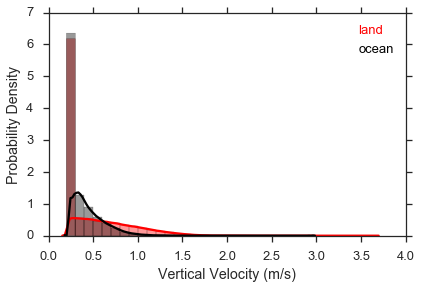

In [4]:
from util import colortext_legend

def wsub_plot(wsub_subset, ax):

    lnd_mask = wsub_subset['ORO'] == 1.
    ocn_mask = wsub_subset['ORO'] == 0.

    kde_kws = dict(kde=True, norm_hist=True, ax=ax, 
                   bins=np.arange(0.2, 3.1, 0.1))
    
    colors = {'land': 'r', 'ocean': 'k'}

    for (label, mask) in [('land', lnd_mask,), 
                                 ('ocean', ocn_mask,)]:
        color = colors[label]
        sns.distplot(wsub_subset.loc[mask, 'WSUB'], label=label, color=color,
                     **kde_kws)

    ax.set_xlabel("Vertical Velocity (m/s)")
    ax.set_ylabel("Probability Density")
    
    leg = colortext_legend(colors, loc='upper right')

    return ax

size = 4.
aspect = 16./10.
height, width = size, size*aspect
figsize = (width, height)

fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = wsub_plot(wsub_subset, ax)
plt.savefig("figs/wsub_land_vs_ocean.pdf", transparent=True, bbox_inches='tight')

In [5]:
wsub_subset.loc[(wsub_subset["ORO"] == 0.), "region"] = "ocean"
wsub_subset.loc[(wsub_subset["ORO"] == 1.), "region"] = "land"
(wsub_subset
     .dropna()
     .groupby('region')
     ['WSUB']
     .describe()
)

region       
land    count    1.951110e+06
        mean     4.079413e-01
        std      3.353662e-01
        min      2.000000e-01
        25%      2.000000e-01
        50%      2.000000e-01
        75%      5.540058e-01
        max      3.651484e+00
ocean   count    4.458510e+06
        mean     3.193772e-01
        std      1.813006e-01
        min      2.000000e-01
        25%      2.000000e-01
        50%      2.000000e-01
        75%      3.878471e-01
        max      2.963245e+00
Name: WSUB, dtype: float64

---

Second, we'll show the vertical structure of total dust number concentration, broken down into 20-degree latitude spans, starting from 70S and going to 70N. This is a bit more involved, so we break apart the process. First, we need to subset and bin the data, which is made easy by [`pandas.cut()`](http://pandas.pydata.org/pandas-docs/version/0.17.1/generated/pandas.cut.html).

In [35]:
MARC_data['nDST'] = (
    MARC_data['nDST01'] + MARC_data['nDST02'] + MARC_data['nDST03'] 
    + MARC_data['nDST04']
)
MARC_data['nSSLT'] = (
    MARC_data['nSSLT01'] + MARC_data['nSSLT02'] + MARC_data['nSSLT03'] 
    + MARC_data['nSSLT04']
) 

subset = (
    MARC_data[['nDST', 'nSSLT', 'nACC', 'nMBS']]
    .sel(lat=slice(-70, 70),
         lev=slice(200, None))
    .to_dataframe()
    .reset_index()
    .drop(['lon', 'time'], axis=1)
    .rename(columns={'nDST': 'DST', 'nSSLT': 'SSLT',
                     'nACC': 'ACC', 'nMBS': "MBS"})
)

In [36]:
# Bin the dust data into 20-degree latitude intervals
edges = [-70, -30, 0, 30, 70]
lat_labels = ["70-30$^\circ$ S", "30$^\circ$ S-Eq", "Eq-30$^\circ$ N", "30-70$^\circ$ N"]

lat_bins = pd.cut(subset['lat'], edges, labels=lat_labels)
subset = (
    subset
    .drop('lat', axis=1)
    .assign(lat_bins=lat_bins)
)

In [37]:
# Bin the data by ~200 mb blocks
edges = [200, 400, 600, 800, 1200]
lev_labels = ["400-200 mb", "600-400 mb", "800-600 mb", "Sfc-800mb"]
lev_bins = pd.cut(subset['lev'], edges, labels=lev_labels)
subset = (
    subset
    .drop('lev', axis=1)
    .assign(lev_bins=lev_bins)
)

In [38]:
subset_tidy = pd.melt(subset.sample(frac=0.03), id_vars=['lev_bins', 'lat_bins'], 
                      value_vars=['DST', 'SSLT', 'ACC', 'MBS'])
subset_tidy[subset_tidy.value < 1e-8] = np.nan
subset_tidy.dropna()
subset_tidy.loc[pd.IndexSlice[:], 'value'] = np.log10(subset_tidy.value)

subset_tidy.head()

,lev_bins,lat_bins,variable,value
0,Sfc-800mb,70-30$^\circ$ S,DST,-6.897649
1,Sfc-800mb,Eq-30$^\circ$ N,DST,-4.799879
2,800-600 mb,Eq-30$^\circ$ N,DST,-1.659057
3,400-200 mb,30-70$^\circ$ N,DST,-2.812311
4,800-600 mb,30-70$^\circ$ N,DST,-2.941546


## Figure - ACC, MBS, DST, SSLT violinplots aggregated by lat/lev

/Users/daniel/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


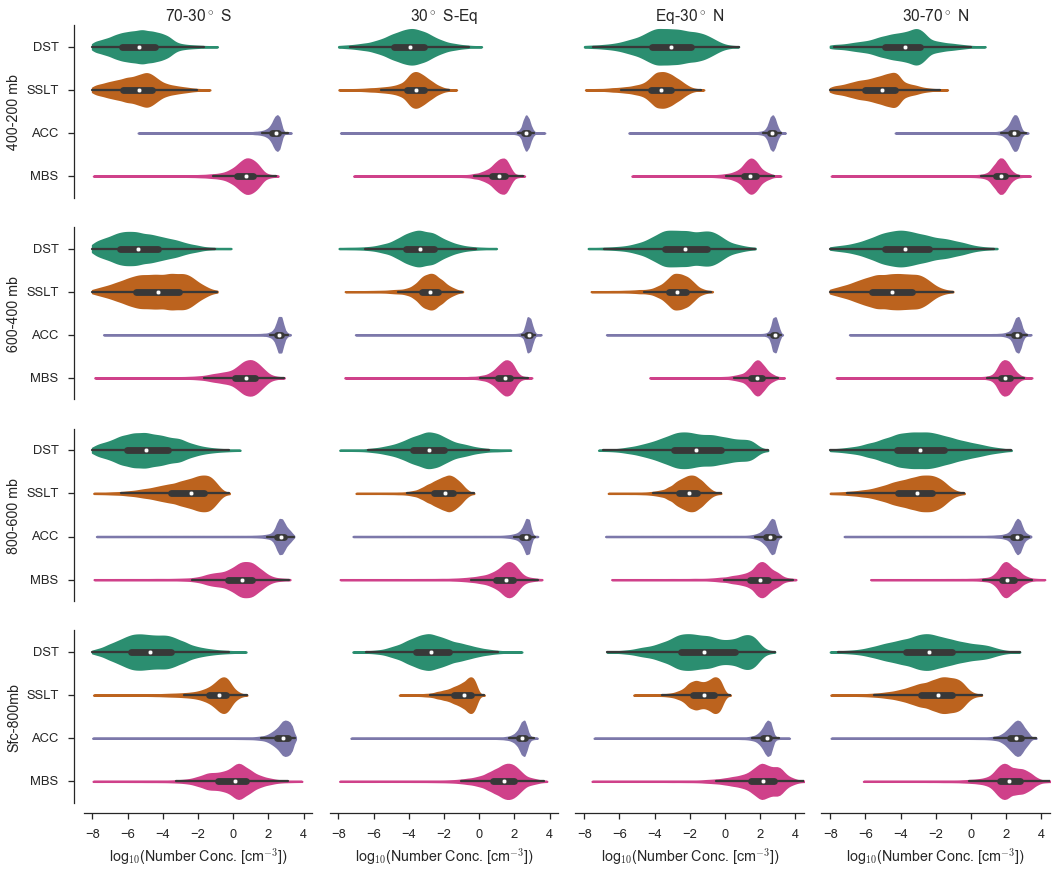

In [41]:
import matplotlib.ticker as mticker

g = sns.FacetGrid(subset_tidy, row='lev_bins', col='lat_bins', 
                  row_order=lev_labels, col_order=lat_labels,
                  aspect=1.25, )

def _violinplot(*args, **kwargs):
    if 'label' in kwargs:
        kwargs.pop('label')
    kwargs['palette'] = 'Dark2'
    return sns.violinplot(*args, **kwargs)
g.map(_violinplot, "value", "variable",
      orient='h', scale='count', cut=0.)

for ax in g.axes.flat:
    # ax.semilogx()
    ax.set_title("")
    ax.set_xlim(-8.5, 4.5)    
    # ax.xaxis.set_major_locator(mticker.LogLocator(numticks=5))
for ax, label in zip(g.axes[0, :], lat_labels):
    ax.set_title(label)
for ax in g.axes[-1, :]:
    ax.set_xlabel("log$_{\mathrm{10}}$(Number Conc. [cm$^{-3}$])")
for ax, label in zip(g.axes[:, 0], lev_labels):
    ax.set_ylabel(label)
plt.subplots_adjust(wspace=0.075)

# Tweak spines
nx, ny = g.axes.shape
for i in range(nx):
    for j in range(ny):
        left = i > 0
        bottom = j < (ny-1)
        ax = g.axes[j, i]
        sns.despine(ax=ax, left=left, bottom=bottom, offset=10)
        if left: ax.yaxis.set_visible(False)
        if bottom: ax.xaxis.set_visible(False)

plt.savefig("figs/N_pdf_by_lev_and_lat.pdf", transparent=True, bbox_inches='tight')

---

## Table(s) - Global Percentiles

In [25]:
pd.set_option('display.max_columns', 9999)
pd.set_option('precision', 1)

from util import all_modes, _to_str

In [26]:
from collections import OrderedDict

def mode_percentiles(data, param='n', percentiles=[.1, 1., 2., 5., 10.],
                     lo=1e-30, hi=1e30):
    """ Compute percentiles of a specific parameter for each mode in a given
    dataset. 'percentiles' will be mirrored around the median, so only the
    lower values need to be provided. """
    all_mode_percentiles = {}
    for mode in all_modes:
        try:
            aer_data = data[param + mode].values.ravel()
        except KeyError:
            continue
        aer_data = aer_data[(aer_data > lo) & (aer_data < hi)]
        pcts = np.array(percentiles + [100. - p for p in percentiles[::-1]])
        tiles = list(np.percentile(aer_data, pcts))
        vals = zip(['min', ] + [_to_str(p) for p in pcts] + ['max', ],
                   [np.min(aer_data), ] + tiles + [np.max(aer_data), ])
        mode_percentiles = pd.Series(OrderedDict(vals))
        all_mode_percentiles[mode] = mode_percentiles
    return pd.DataFrame(all_mode_percentiles)

def _label_pct(x):
    if x not in ['min', 'max']:
        return "{}\%".format(x)
    else:
        return x

In [27]:
data = (
    MARC_data
    .sel(lat=slice(-70, 70), lev=slice(500, 1100))
    #.isel(time=slice(-1, None))
)

In [33]:
mu_pcts = (
    data
    .pipe(mode_percentiles, 'mu')
    [all_modes[:-8]]
    .rename(index=_label_pct)
    .to_latex(escape=False)
)
print("mu\n\n", mu_pcts)

mu

 \begin{tabular}{lrrrrrrr}
\toprule
{} &      NUC &      AIT &      ACC &       OC &      MOS &       BC &      MBS \\
\midrule
min    &  5.0e-11 &  1.2e-10 &  8.4e-11 &  7.3e-11 &  1.7e-10 &  7.4e-11 &  1.4e-10 \\
0.1\%  &  4.1e-09 &  1.4e-08 &  4.2e-05 &  2.6e-03 &  2.1e-03 &  7.5e-04 &  1.4e-06 \\
1\%    &  2.2e-08 &  7.8e-04 &  2.2e-03 &  1.3e-02 &  3.5e-03 &  4.8e-03 &  1.9e-03 \\
2\%    &  5.2e-08 &  8.6e-04 &  2.9e-03 &  1.9e-02 &  4.3e-03 &  7.0e-03 &  2.3e-03 \\
5\%    &  4.7e-07 &  9.8e-04 &  4.6e-03 &  2.1e-02 &  5.8e-03 &  1.2e-02 &  3.1e-03 \\
10\%   &  8.5e-04 &  1.1e-03 &  6.9e-03 &  2.2e-02 &  7.9e-03 &  1.2e-02 &  4.0e-03 \\
90\%   &  1.4e-02 &  5.7e-03 &  7.0e-02 &  7.9e-02 &  2.6e-02 &  4.1e-02 &  1.5e-02 \\
95\%   &  1.8e-02 &  8.7e-03 &  9.5e-02 &  1.0e-01 &  3.0e-02 &  5.5e-02 &  1.9e-02 \\
98\%   &  2.2e-02 &  1.7e-02 &  1.5e-01 &  1.6e-01 &  7.1e-02 &  8.7e-02 &  3.5e-02 \\
99\%   &  2.6e-02 &  3.7e+04 &  1.1e+01 &  2.4e+04 &  2.4e+04 &  2.4e+04 &  2.4e+04 \

In [32]:
n_pcts = (
    data
    .pipe(mode_percentiles, 'n')
    [all_modes]
    .rename(index=_label_pct)
    .to_latex(escape=False)
)
print("N\n\n", n_pcts)

N

 \begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
{} &      NUC &      AIT &      ACC &       OC &      MOS &       BC &      MBS &    DST01 &    DST02 &    DST03 &    DST04 &   SSLT01 &   SSLT02 &   SSLT03 &   SSLT04 \\
\midrule
min    &  6.0e-29 &  1.7e-23 &  2.0e-30 &  1.6e-17 &  2.8e-16 &  5.5e-18 &  2.7e-16 &  2.1e-27 &  1.3e-29 &  1.3e-29 &  1.8e-30 &  1.9e-28 &  5.0e-30 &  1.2e-30 &  1.0e-30 \\
0.1\%  &  6.7e-14 &  5.2e-08 &  2.2e-09 &  4.3e-04 &  7.5e-05 &  6.7e-07 &  1.3e-06 &  5.3e-10 &  1.1e-11 &  4.1e-12 &  6.1e-14 &  1.2e-08 &  1.1e-09 &  1.0e-11 &  3.2e-21 \\
1\%    &  6.7e-10 &  3.6e-05 &  3.4e+00 &  1.6e-02 &  9.7e-03 &  9.0e-04 &  3.1e-03 &  1.9e-08 &  3.9e-10 &  1.5e-10 &  2.9e-12 &  5.9e-07 &  6.3e-08 &  6.6e-10 &  6.3e-18 \\
2\%    &  3.2e-08 &  1.8e-04 &  1.6e+01 &  3.5e-02 &  4.1e-02 &  3.7e-03 &  1.1e-02 &  5.8e-08 &  1.2e-09 &  5.5e-10 &  1.1e-11 &  2.4e-06 &  2.9e-07 &  3.3e-09 &  1.6e-16 \\
5\%    &  5.3e-07 &  1.6e-03 &  5.0e+01 &  6.9e-02 &  2.2e-01 &  1.6e-02 

At what percentile in the sampling data do the bounds chosen for MARC occur?

In [22]:
from statsmodels.distributions import ECDF
from scipy.optimize import brentq


N_bnds = {
    'ACC': [-3, 4], 'MOS': [-5, 4], 'MBS': [-5, 4],
    'DST01': [-5, 2], 'DST02': [-5, 1], 'SSLT01': [-5, 1]
}
mu_bnds = {
    'ACC': [-3, 0], 'MOS': [-3, -1], 'MBS': [-3, -1]
}

print("N")
print("-----------------")
for mode, (lo, hi) in N_bnds.items():
    print(mode, end=" ")
    d = np.log10(
        data['n'+mode]
        #.to_dataframe()
        #.sample(n=100)
        #.reset_index()
        #['n'+mode]
    )
    def _root(pctile, zero):
        return np.percentile(d, pctile) - zero
    
    if lo < d.min():
        left = 0.
    else:
        left = brentq(_root, 0., 50., args=(lo, ))
    if hi > d.max():
        right = 100.
    else:
        right = brentq(_root, 50., 100., args=(hi, ))
    print(left, right)
    
print("\nmu")
print("-----------------")
for mode, (lo, hi) in mu_bnds.items():
    print(mode, end=" ")
    d = np.log10(
        data['mu'+mode]
        #.to_dataframe()
        #.sample(n=100)
        #.reset_index()
        #['mu'+mode]
    )
    def _root(pctile, zero):
        return np.percentile(d, pctile) - zero
    
    if lo < d.min():
        left = 0.
    else:
        left = brentq(_root, 0., 50., args=(lo, ))
    if hi > d.max():
        right = 100.
    else:
        right = brentq(_root, 50., 100., args=(hi, ))
    print(left, right)

N
-----------------
SSLT01 3.646661293151296 100.0
MBS 1.5891327810002567 99.79858277686583
DST01 18.166688562846584 99.81973325166221
ACC 1.1799559563574622 99.99995304108765
DST02 38.97832411675241 99.97009949938224
MOS 1.4778436847955847 99.94030515838607

mu
-----------------
ACC 0.12552358939064812 98.93465427069515
MOS 0.06077441196497914 98.30087882459752
MBS 0.1157778843960352 98.54463582634627
